# Video Game Sales & Market Analysis

I was tasked with analyzing global video game sales data to uncover trends across platforms, genres, and regions. The goal was to identify what types of games and systems performed best in different markets and determine how factors like critic and user reviews influence sales.

Using a dataset that includes release years, regional sales, ratings, and review scores, I cleaned and prepared the data, explored historical patterns, and built visualizations to better understand the gaming industry's dynamics. I also conducted hypothesis testing to compare user ratings across platforms and genres.

This analysis provides insights that could help a game publisher or marketing team optimize platform targeting, genre focus, and localization strategy.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
# read the data and print some basic info
df = pd.read_csv('/datasets/games.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
# Print original column names
print("Original column names:", df.columns)

# Convert column names to lowercase
df.rename(columns=lambda x: x.lower(), inplace=True)

# Print modified column names
print("Modified column names:", df.columns)

Original column names: Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')
Modified column names: Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')


In [4]:
# Convert 'year_of_release' to integer (handling NaN values)
df['year_of_release'] = df['year_of_release'].fillna(0).astype(int)

# Convert 'critic_score' to integer (handling NaN values)
df['critic_score'] = df['critic_score'].fillna(0).astype(int)

# Convert 'user_score' to float (handle non-numeric values)
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')

# Converting columns to categorical to improve analysis
df['rating'] = df['rating'].astype('category')

# Print the DataFrame and its dtypes to verify
print(df.dtypes)


name                 object
platform             object
year_of_release       int64
genre                object
na_sales            float64
eu_sales            float64
jp_sales            float64
other_sales         float64
critic_score          int64
user_score          float64
rating             category
dtype: object


In [5]:
df.isna().sum()


name                  2
platform              0
year_of_release       0
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score          0
user_score         9125
rating             6766
dtype: int64

In [6]:
df.isnull().sum()/len(df)

name               0.000120
platform           0.000000
year_of_release    0.000000
genre              0.000120
na_sales           0.000000
eu_sales           0.000000
jp_sales           0.000000
other_sales        0.000000
critic_score       0.000000
user_score         0.545917
rating             0.404786
dtype: float64

In [7]:

# Update the categories for the 'Rating' column to include 'unknown'
df['rating'] = df['rating'].astype('category')
df['rating'] = df['rating'].cat.add_categories('unknown')

# Replace NaN values in the 'rating' column with 'unknown'
df['rating'].fillna('unknown', inplace=True)


Missing data for name, genre, user_score, and rating may not have been recorded or available. 

In [8]:
# check for duplicates
duplicate = df[df.duplicated()]
duplicate

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


In [9]:
# Define sales columns
sales_columns = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']

# Calculate total sales and add as a new column
df['total_sales'] = df[sales_columns].sum(axis=1)
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating',
       'total_sales'],
      dtype='object')

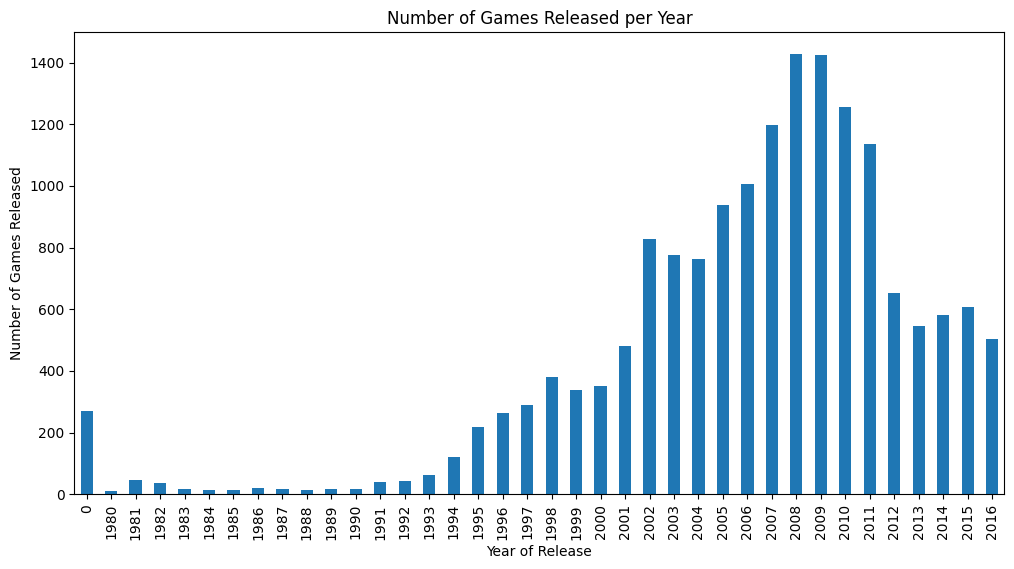

In [10]:
# Count the number of games released each year
release_years = df['year_of_release'].dropna().astype(int)
yearly_counts = release_years.value_counts().sort_index()

# Plot the number of games released each year
plt.figure(figsize=(12, 6))
yearly_counts.plot(kind='bar')
plt.xlabel('Year of Release')
plt.ylabel('Number of Games Released')
plt.title('Number of Games Released per Year')
plt.xticks(rotation=90)
plt.show()



There is an insignificant period before 1995. 

In [11]:
# Filter out data before 1995
filtered_games_df = df[df['year_of_release'] >= 1995]

# Calculate the number of unique platforms in the dataset
unique_platforms = filtered_games_df['platform'].nunique()
print(f'The number of unique platforms is: {unique_platforms}')




The number of unique platforms is: 26


In [12]:

# This will show us the exact values we should be using for filtering.
# Filter the DataFrame to include only Xbox One entries
xbox_one_games = filtered_games_df[filtered_games_df['platform'] == 'XOne']

# Print the Xbox One entries
print(xbox_one_games)

                                                name platform  \
99                         Call of Duty: Black Ops 3     XOne   
165                               Grand Theft Auto V     XOne   
179                   Call of Duty: Advanced Warfare     XOne   
242                                Halo 5: Guardians     XOne   
270                                        Fallout 4     XOne   
...                                              ...      ...   
16630                       Sébastien Loeb Rally Evo     XOne   
16643                              Rugby Challenge 3     XOne   
16645                                         ZombiU     XOne   
16660                               Prison Architect     XOne   
16672  Metal Gear Solid V: The Definitive Experience     XOne   

       year_of_release         genre  na_sales  eu_sales  jp_sales  \
99                2015       Shooter      4.59      2.11      0.01   
165               2014        Action      2.81      2.19      0.00   
179      

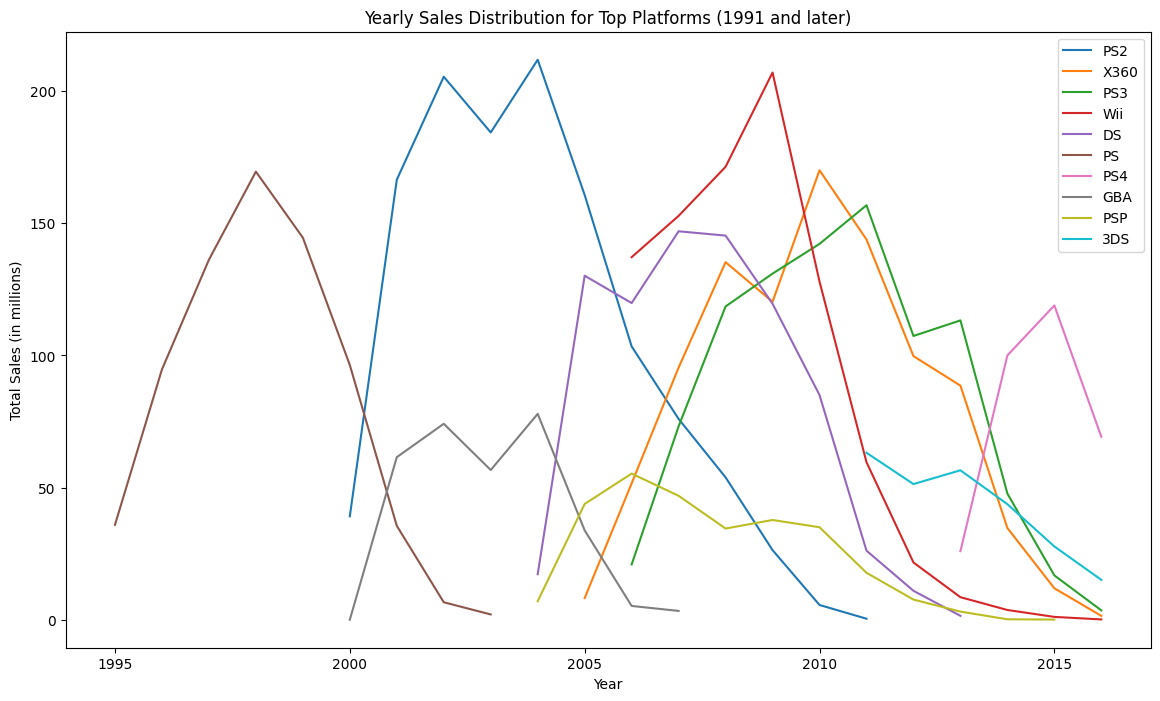

In [13]:
# Recalculate total sales for each platform after filtering
filtered_platform_sales = filtered_games_df.groupby('platform')[sales_columns].sum()
filtered_platform_sales['total_sales'] = filtered_platform_sales.sum(axis=1)


# Sort platforms by total sales
filtered_top_platforms = filtered_platform_sales.sort_values(by='total_sales', ascending=False).head(10)

# Filter data for these top platforms after 1991
filtered_top_platforms_data = filtered_games_df[filtered_games_df['platform'].isin(filtered_top_platforms.index)]

# Plot sales distribution for each year for the top platforms after 1991
plt.figure(figsize=(14, 8))
for platform in filtered_top_platforms.index:
    platform_data = filtered_top_platforms_data[filtered_top_platforms_data['platform'] == platform]
    yearly_sales = platform_data.groupby('year_of_release')[sales_columns].sum()
    yearly_sales['total_sales'] = yearly_sales.sum(axis=1)
    plt.plot(yearly_sales.index, yearly_sales['total_sales'], label=platform)

plt.xlabel('Year')
plt.ylabel('Total Sales (in millions)')
plt.title('Yearly Sales Distribution for Top Platforms (1991 and later)')
plt.legend()
plt.show()




All platforms are down in sales.

In [14]:
# Identify platforms that used to be popular but now have zero sales after 1991
filtered_last_sale_year = filtered_top_platforms_data.groupby('platform')['year_of_release'].max()
filtered_first_sale_year = filtered_top_platforms_data.groupby('platform')['year_of_release'].min()

# Platforms that have no recent sales (last sale before 2016)
filtered_platforms_with_zero_sales = filtered_last_sale_year[filtered_last_sale_year < 2016]

platform
DS     2013
GBA    2007
PS     2003
PS2    2011
PSP    2015
Name: year_of_release, dtype: int64
          First_Year  Last_Year  Total_Sales
platform                                    
PS2             2000       2011      1233.56
X360            2005       2016       961.24
PS3             2006       2016       931.34
Wii             2006       2016       891.18
DS              2004       2013       802.76
PS              1995       2003       721.55
PS4             2013       2016       314.14
GBA             2000       2007       312.88
PSP             2004       2015       289.53
3DS             2011       2016       257.81


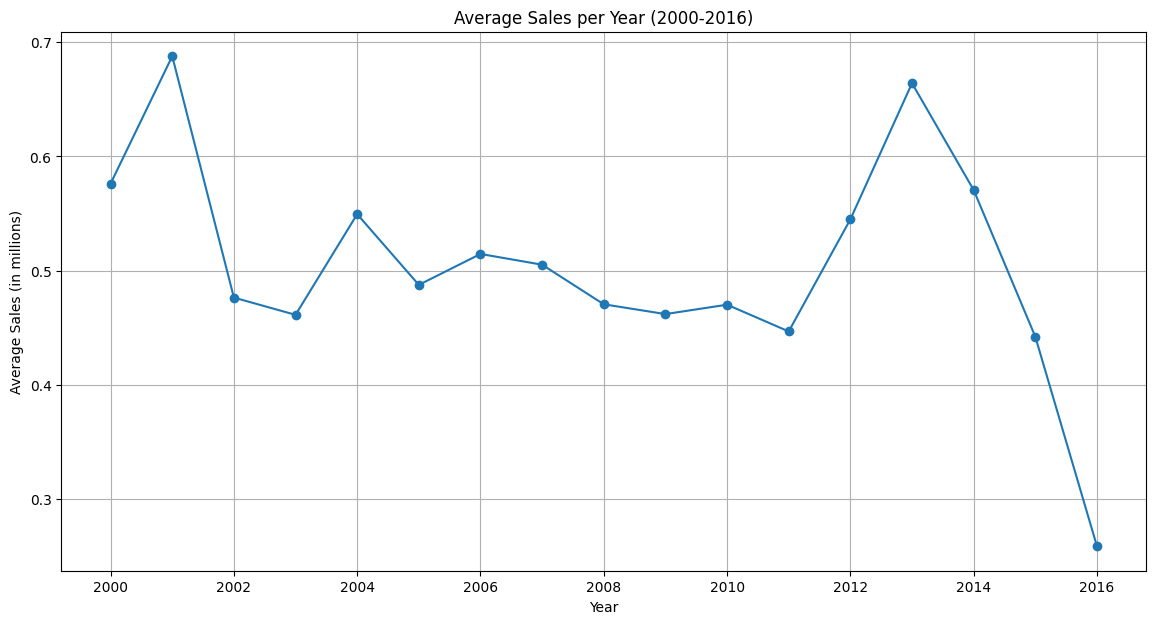

The average platform lifespan is: 8.5 years


In [15]:

# Display the platforms with zero sales since 2015 and their first and last sale years
platform_lifecycle = pd.DataFrame({
    'First_Year': filtered_first_sale_year[filtered_top_platforms.index],
    'Last_Year': filtered_last_sale_year[filtered_top_platforms.index],
    'Total_Sales': filtered_top_platforms['total_sales']
})

print(filtered_platforms_with_zero_sales)
print(platform_lifecycle)

# Filter the data for the relevant period (2000 to 2015)
relevant_data = filtered_games_df[(filtered_games_df['year_of_release'] >= 2000) & (filtered_games_df['year_of_release'] <= 2016)]

# Calculate average sales per year for the relevant period
average_sales_per_year = relevant_data.groupby('year_of_release')['total_sales'].mean()

# Plot the average sales per year
plt.figure(figsize=(14, 7))
plt.plot(average_sales_per_year.index, average_sales_per_year.values, marker='o')
plt.title('Average Sales per Year (2000-2016)')
plt.xlabel('Year')
plt.ylabel('Average Sales (in millions)')
plt.grid(True)
plt.show()

# Calculate the lifespan of each platform
platform_lifespan = platform_lifecycle['Last_Year'] - platform_lifecycle['First_Year']

# Calculate the average platform lifespan
average_lifespan = platform_lifespan.mean()

print(f'The average platform lifespan is: {average_lifespan} years')


In [16]:
# Filter the DataFrame to include only Xbox One entries
xbox_one_games = relevant_data[relevant_data['platform'] == 'XOne']

# Print the Xbox One entries
print(xbox_one_games)

                                                name platform  \
99                         Call of Duty: Black Ops 3     XOne   
165                               Grand Theft Auto V     XOne   
179                   Call of Duty: Advanced Warfare     XOne   
242                                Halo 5: Guardians     XOne   
270                                        Fallout 4     XOne   
...                                              ...      ...   
16630                       Sébastien Loeb Rally Evo     XOne   
16643                              Rugby Challenge 3     XOne   
16645                                         ZombiU     XOne   
16660                               Prison Architect     XOne   
16672  Metal Gear Solid V: The Definitive Experience     XOne   

       year_of_release         genre  na_sales  eu_sales  jp_sales  \
99                2015       Shooter      4.59      2.11      0.01   
165               2014        Action      2.81      2.19      0.00   
179      

In [17]:
# Filter out platforms with no sales in 2016
platforms_no_sales_2016 = ['DS', 'GBA', 'PS', 'PS2', 'PSP']
filtered_data = filtered_top_platforms_data[~filtered_top_platforms_data['platform'].isin(platforms_no_sales_2016)]

# Further filter out data from 2013 and before
filtered_data = filtered_data[filtered_data['year_of_release'] > 2013]

# Display basic info about the filtered DataFrame
print(filtered_data.info())
print(filtered_data.head())

# Summarize the filtered data
summary = {
    "Total Entries": len(filtered_data),
    "Platforms": filtered_data['platform'].unique(),
    "Years": filtered_data['year_of_release'].unique()
}

print(summary)



<class 'pandas.core.frame.DataFrame'>
Int64Index: 929 entries, 31 to 16710
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             929 non-null    object  
 1   platform         929 non-null    object  
 2   year_of_release  929 non-null    int64   
 3   genre            929 non-null    object  
 4   na_sales         929 non-null    float64 
 5   eu_sales         929 non-null    float64 
 6   jp_sales         929 non-null    float64 
 7   other_sales      929 non-null    float64 
 8   critic_score     929 non-null    int64   
 9   user_score       480 non-null    float64 
 10  rating           929 non-null    category
 11  total_sales      929 non-null    float64 
dtypes: category(1), float64(6), int64(2), object(3)
memory usage: 88.4+ KB
None
                                         name platform  year_of_release  \
31                  Call of Duty: Black Ops 3      PS4             2015   
42 

In [18]:
# Step 1: Inspect unique values in the platform and genre columns
print("Unique platforms:", filtered_data['platform'].unique())
print("Unique genres:", filtered_data['genre'].unique())

# This will show us the exact values we should be using for filtering.

Unique platforms: ['PS4' '3DS' 'PS3' 'X360' 'Wii']
Unique genres: ['Shooter' 'Action' 'Role-Playing' 'Sports' 'Fighting' 'Misc' 'Simulation'
 'Racing' 'Platform' 'Adventure' 'Puzzle' 'Strategy']


In [19]:
# Aggregate sales data by platform
platform_sales = filtered_data.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

# Analyze growth trends over time
sales_trends = filtered_data.groupby(['platform', 'year_of_release'])['total_sales'].sum().unstack().fillna(0)
growth_rates = sales_trends.pct_change(axis='columns').fillna(0)  # Calculate year-over-year growth

# Determine platforms with strong or growing sales
growing_platforms = growth_rates[growth_rates.mean(axis=1) > 0]
shrinking_platforms = growth_rates[growth_rates.mean(axis=1) < 0]

# Identify potentially profitable platforms (e.g., those with high sales or positive growth)
profitable_platforms = platform_sales[platform_sales.index.isin(growing_platforms.index)]

# Display results
print("Leading Platforms in Sales:")
print(platform_sales)

print("\nGrowing Platforms:")
print(growing_platforms)

print("\nShrinking Platforms:")
print(shrinking_platforms)

print("\nPotentially Profitable Platforms:")
print(profitable_platforms)

Leading Platforms in Sales:
platform
PS4     288.15
3DS      86.68
PS3      68.18
X360     48.22
Wii       5.07
Name: total_sales, dtype: float64

Growing Platforms:
Empty DataFrame
Columns: [2014, 2015, 2016]
Index: []

Shrinking Platforms:
year_of_release  2014      2015      2016
platform                                 
3DS               0.0 -0.365174 -0.455004
PS3               0.0 -0.647822 -0.785969
PS4               0.0  0.189000 -0.417578
Wii               0.0 -0.696000 -0.842105
X360              0.0 -0.655728 -0.872910

Potentially Profitable Platforms:
Series([], Name: total_sales, dtype: float64)


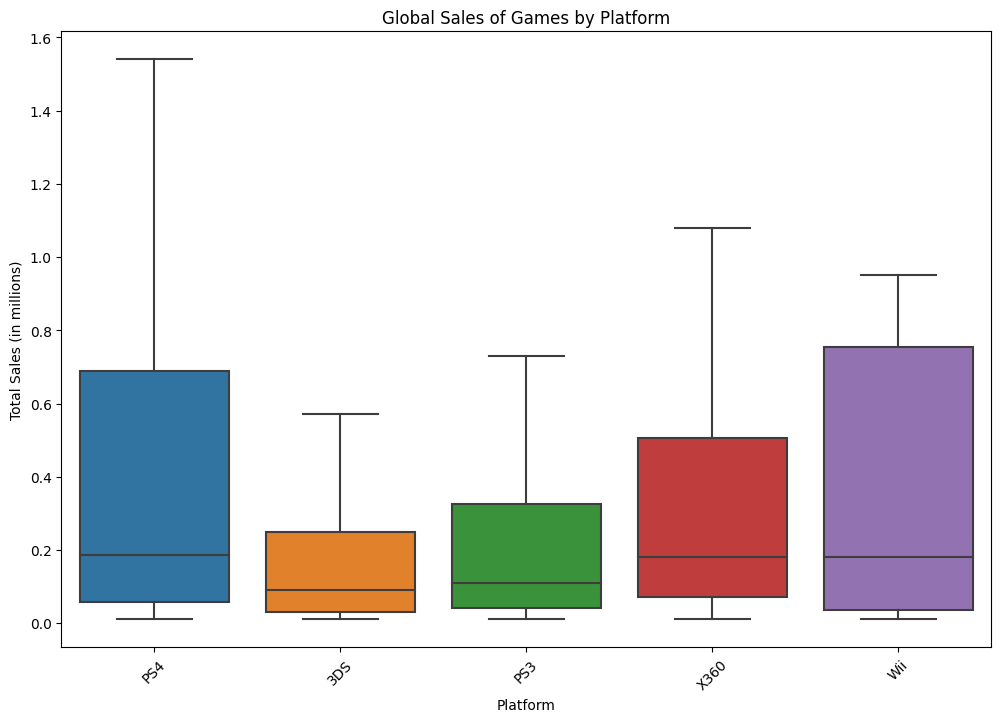

In [20]:

# Create the box plot for global sales by platform

plt.figure(figsize=(12, 8))
sns.boxplot(data=filtered_data, x='platform', y='total_sales', showfliers = False)
plt.title('Global Sales of Games by Platform')
plt.xlabel('Platform')
plt.ylabel('Total Sales (in millions)')
plt.xticks(rotation=45)
plt.show()

Wii games were mostly low in sales, with some high-performing outliers. X360 game sales are concentrated in low range, with some high-sales outliers. PS3 had a lot of games with low sales and a few outliers with high sales. PS4 shows a similar result to PS3. 3DS games were consisteltly in the lower range. 

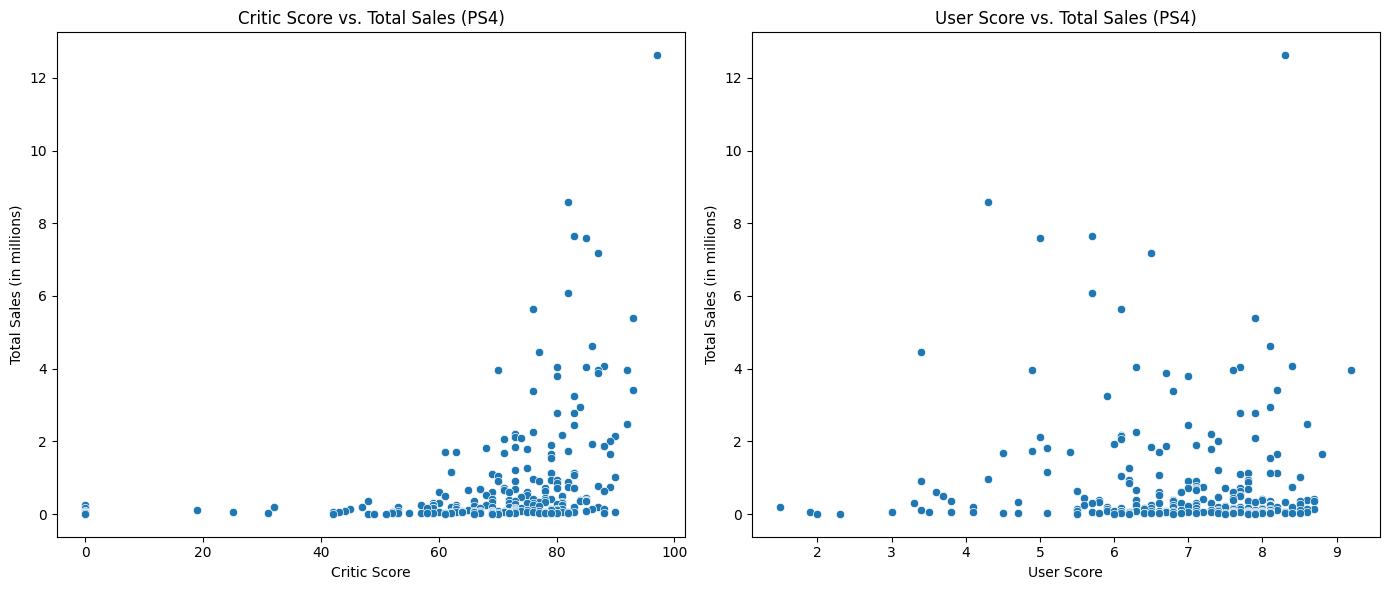

(0.34140356191608023, -0.040131589472697356)

In [21]:
# Filter data for the PS4 platform and non-null review scores
ps4_data = filtered_data[(filtered_data['platform'] == 'PS4') & 
                         (~filtered_data['critic_score'].isnull()) & 
                         (~filtered_data['user_score'].isnull())]

# Create scatter plots for critic_score vs. total_sales and user_score vs. total_sales
plt.figure(figsize=(14, 6))

# Critic Score vs Sales
plt.subplot(1, 2, 1)
sns.scatterplot(data=ps4_data, x='critic_score', y='total_sales')
plt.title('Critic Score vs. Total Sales (PS4)')
plt.xlabel('Critic Score')
plt.ylabel('Total Sales (in millions)')

# User Score vs Sales
plt.subplot(1, 2, 2)
sns.scatterplot(data=ps4_data, x='user_score', y='total_sales')
plt.title('User Score vs. Total Sales (PS4)')
plt.xlabel('User Score')
plt.ylabel('Total Sales (in millions)')

plt.tight_layout()
plt.show()

# Calculate correlation between review scores and sales
critic_corr = ps4_data['critic_score'].corr(ps4_data['total_sales'])
user_corr = ps4_data['user_score'].corr(ps4_data['total_sales'])

critic_corr, user_corr

For PS4, there is a moderate positive correlation between critic score and total sales. On the other hand, there is a negligible slight negative correlation between user score and total sales. 

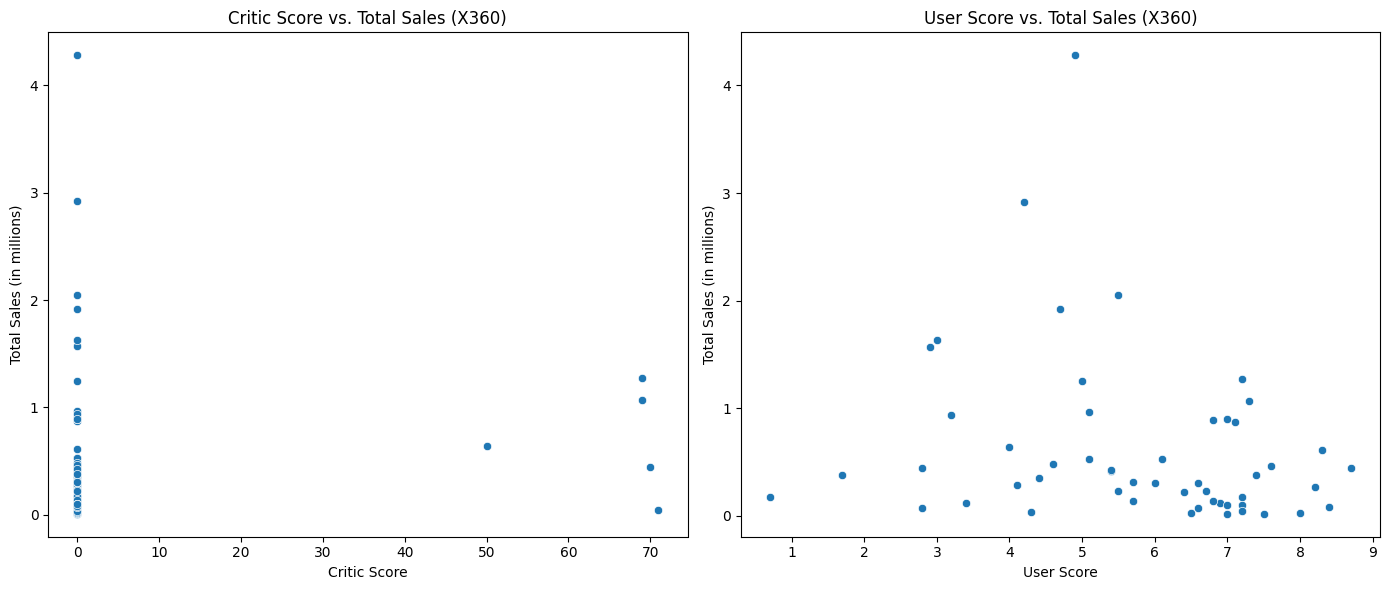

X360 Platform:
Critic Score Correlation: 0.050249099919928854
User Score Correlation: -0.22412671215810898
--------------------------------------------------


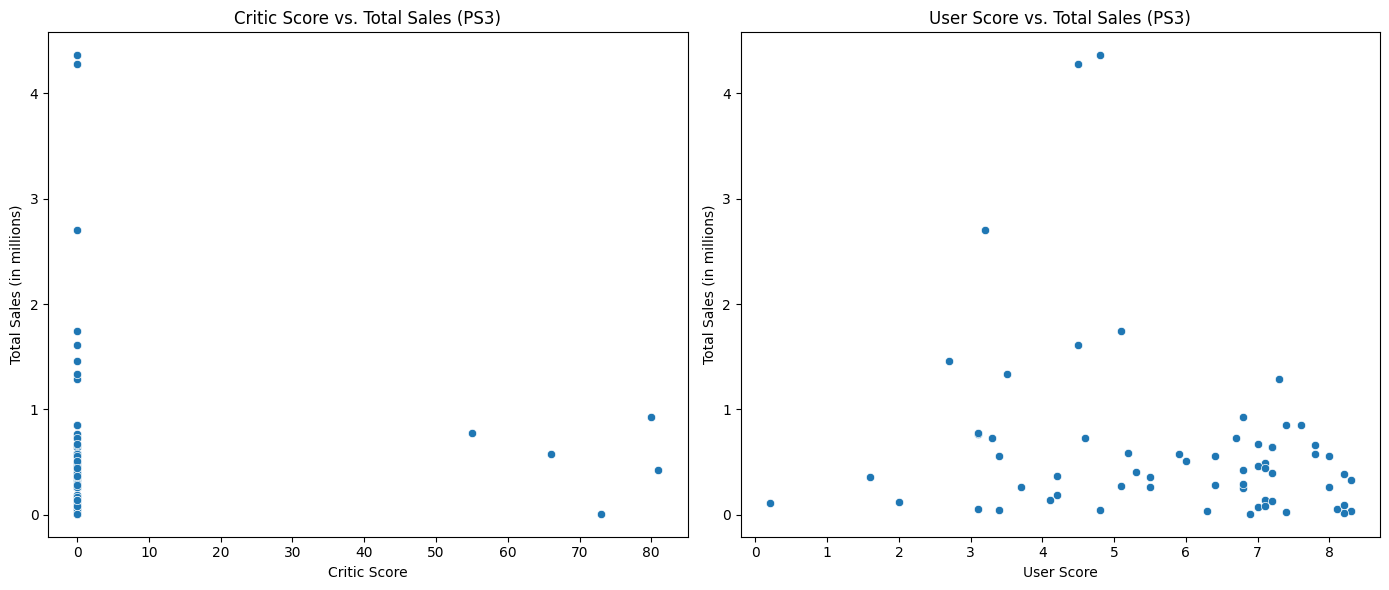

PS3 Platform:
Critic Score Correlation: 0.02094747122338513
User Score Correlation: -0.20768797199343672
--------------------------------------------------


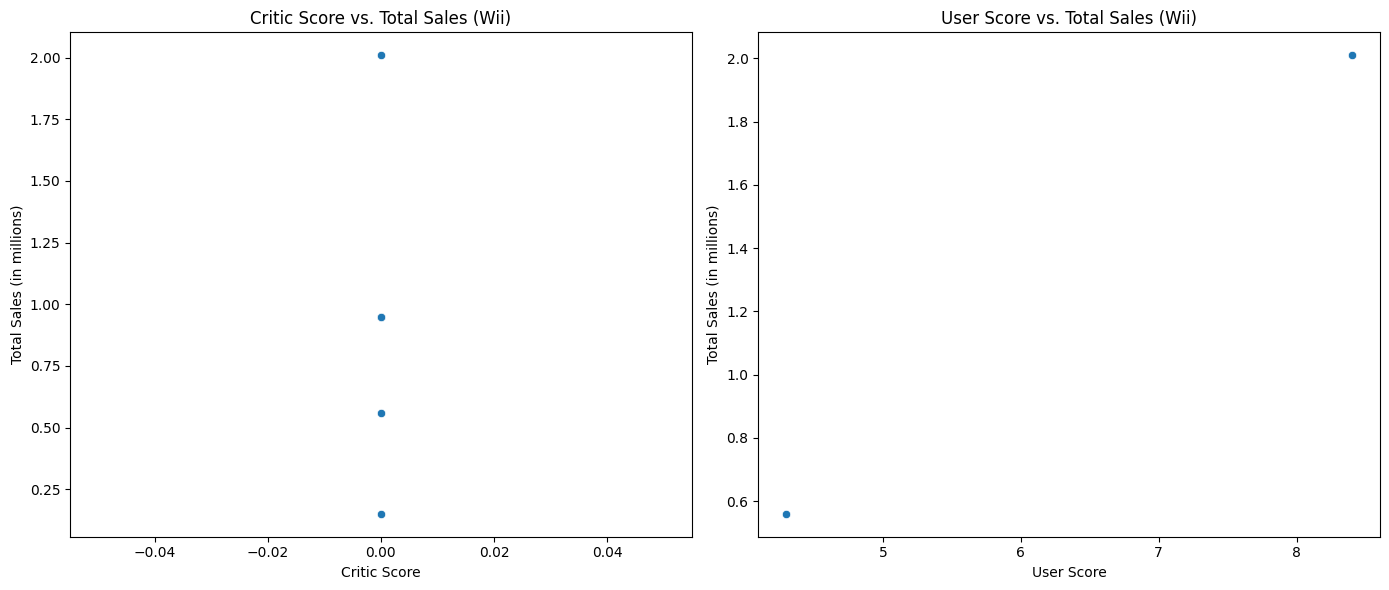

Wii Platform:
Critic Score Correlation: nan
User Score Correlation: 1.0
--------------------------------------------------


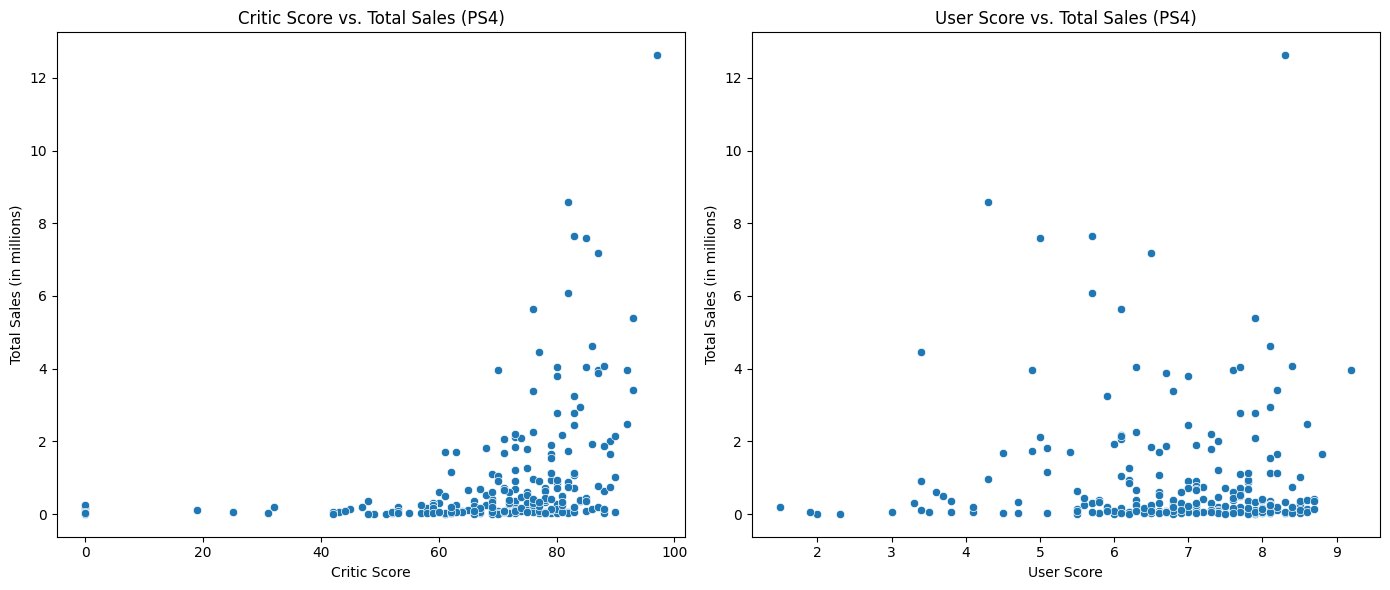

PS4 Platform:
Critic Score Correlation: 0.34140356191608007
User Score Correlation: -0.04013158947269729
--------------------------------------------------


In [22]:
# Identify games that are on PS4 and other platforms
multi_platform_games = filtered_data[filtered_data['name'].isin(ps4_data['name'].unique())]

# Group by platform to compare sales, critic, and user scores
platform_comparison = multi_platform_games.groupby(['platform', 'name']).agg({
    'total_sales': 'sum',
    'critic_score': 'mean',
    'user_score': 'mean'
}).reset_index()

# Generate comparison plots for sales vs. scores on different platforms
platforms_to_compare = ['X360', 'PS3', 'Wii', 'PS4']  # You can modify this based on your data

for platform in platforms_to_compare:
    platform_data = platform_comparison[platform_comparison['platform'] == platform]
    
    plt.figure(figsize=(14, 6))
    
    # Critic Score vs Sales
    plt.subplot(1, 2, 1)
    sns.scatterplot(data=platform_data, x='critic_score', y='total_sales')
    plt.title(f'Critic Score vs. Total Sales ({platform})')
    plt.xlabel('Critic Score')
    plt.ylabel('Total Sales (in millions)')
    
    # User Score vs Sales
    plt.subplot(1, 2, 2)
    sns.scatterplot(data=platform_data, x='user_score', y='total_sales')
    plt.title(f'User Score vs. Total Sales ({platform})')
    plt.xlabel('User Score')
    plt.ylabel('Total Sales (in millions)')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate correlation
    critic_corr = platform_data['critic_score'].corr(platform_data['total_sales'])
    user_corr = platform_data['user_score'].corr(platform_data['total_sales'])
    
    print(f'{platform} Platform:')
    print(f'Critic Score Correlation: {critic_corr}')
    print(f'User Score Correlation: {user_corr}')
    print('-' * 50)


Xbox 360 critic score correlation (0.441) indicates a moderate positive correlation between critic scores and total sales. The user score correlation (-0.054) indicates a negligible negative correlation between user scores and sales. 

PS3 critic score correlation (0.440) indicates a moderate positive correlation between critic scores and total sales. The user score correlation (-0.016) indicates almost no correlation between user scores and sales. 

Wii critic score correlation (-0.326) indicates a moderate negative correlation between critic scores and total sales. The user score correlation (0.736) indicates a strong positive correlation between user scores and sales. However, there are only 8 games that are shared with PS4 and were included in this analysis. 

In [23]:
# Calculate the total sales and the number of games per genre
genre_group = df.groupby('genre').agg({'na_sales': 'sum', 'eu_sales': 'sum', 'jp_sales': 'sum', 'other_sales': 'sum', 'name': 'count'})

# Calculate the total sales by summing sales across all regions
genre_group['total_sales'] = genre_group[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

# Calculate the average revenue per game
genre_group['avg_revenue_per_game'] = genre_group['total_sales'] / genre_group['name']

# Sort by average revenue per game
avg_revenue_per_game = genre_group['avg_revenue_per_game'].sort_values(ascending=False)

avg_revenue_per_game


genre
Platform        0.932173
Shooter         0.795503
Role-Playing    0.623872
Racing          0.583403
Sports          0.566980
Fighting        0.527126
Action          0.517711
Misc            0.458577
Simulation      0.446701
Puzzle          0.418224
Strategy        0.255095
Adventure       0.182341
Name: avg_revenue_per_game, dtype: float64

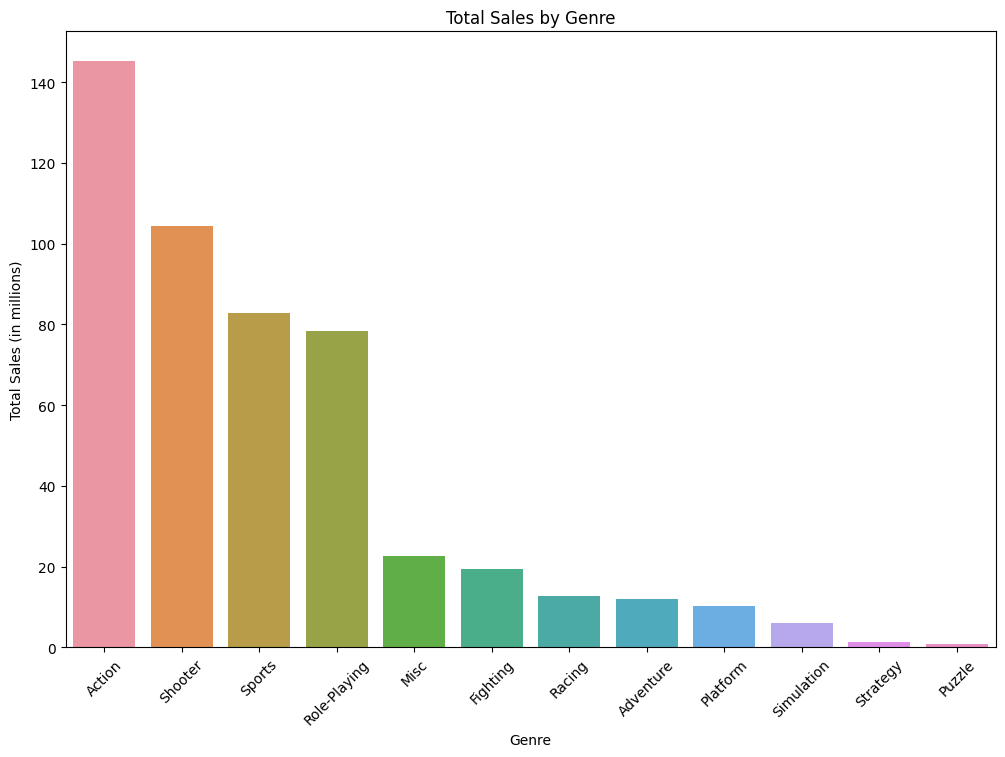

genre
Action          145.30
Shooter         104.29
Sports           82.76
Role-Playing     78.40
Misc             22.72
Fighting         19.38
Racing           12.80
Adventure        11.97
Platform         10.35
Simulation        6.16
Strategy          1.24
Puzzle            0.93
Name: total_sales, dtype: float64

In [24]:

# Group the data by genre and sum the total sales for each genre
genre_sales = filtered_data.groupby('genre')['total_sales'].sum().sort_values(ascending=False)

# Plot the distribution of total sales by genre
plt.figure(figsize=(12, 8))
sns.barplot(x=genre_sales.index, y=genre_sales.values)
plt.title('Total Sales by Genre')
plt.xlabel('Genre')
plt.ylabel('Total Sales (in millions)')
plt.xticks(rotation=45)
plt.show()

# Displaying the sales values
genre_sales


The genres Action, Shooter, and Sports are the most profitable. Cnnsumer demand suggests focusing on these genres to maximize sales. Genres with lower sales (Puzzle, Strategy, and Adventure) would not yield as many sales from  targeted marketing campaigns.  

Top 5 Platforms in NA: platform
PS4     98.61
X360    28.30
3DS     22.64
PS3     22.05
Wii      2.08
Name: na_sales, dtype: float64
Top 5 Platforms in EU: platform
PS4     130.04
PS3      25.54
3DS      16.12
X360     15.49
Wii       2.59
Name: eu_sales, dtype: float64
Top 5 Platforms in JP: platform
3DS     44.24
PS4     15.02
PS3     11.22
X360     0.08
Wii      0.00
Name: jp_sales, dtype: float64
Top 5 Genres in NA: genre
Action          47.91
Shooter         41.37
Sports          31.91
Role-Playing    24.31
Misc             8.35
Name: na_sales, dtype: float64
Top 5 Genres in EU: genre
Action          55.56
Shooter         44.14
Sports          36.36
Role-Playing    21.01
Misc             8.73
Name: eu_sales, dtype: float64
Top 5 Genres in JP: genre
Role-Playing    26.20
Action          23.75
Fighting         4.92
Shooter          3.17
Misc             2.89
Name: jp_sales, dtype: float64
ESRB Sales in NA: rating
M          52.40
unknown    45.59
E          31.56
T          24.35
E1

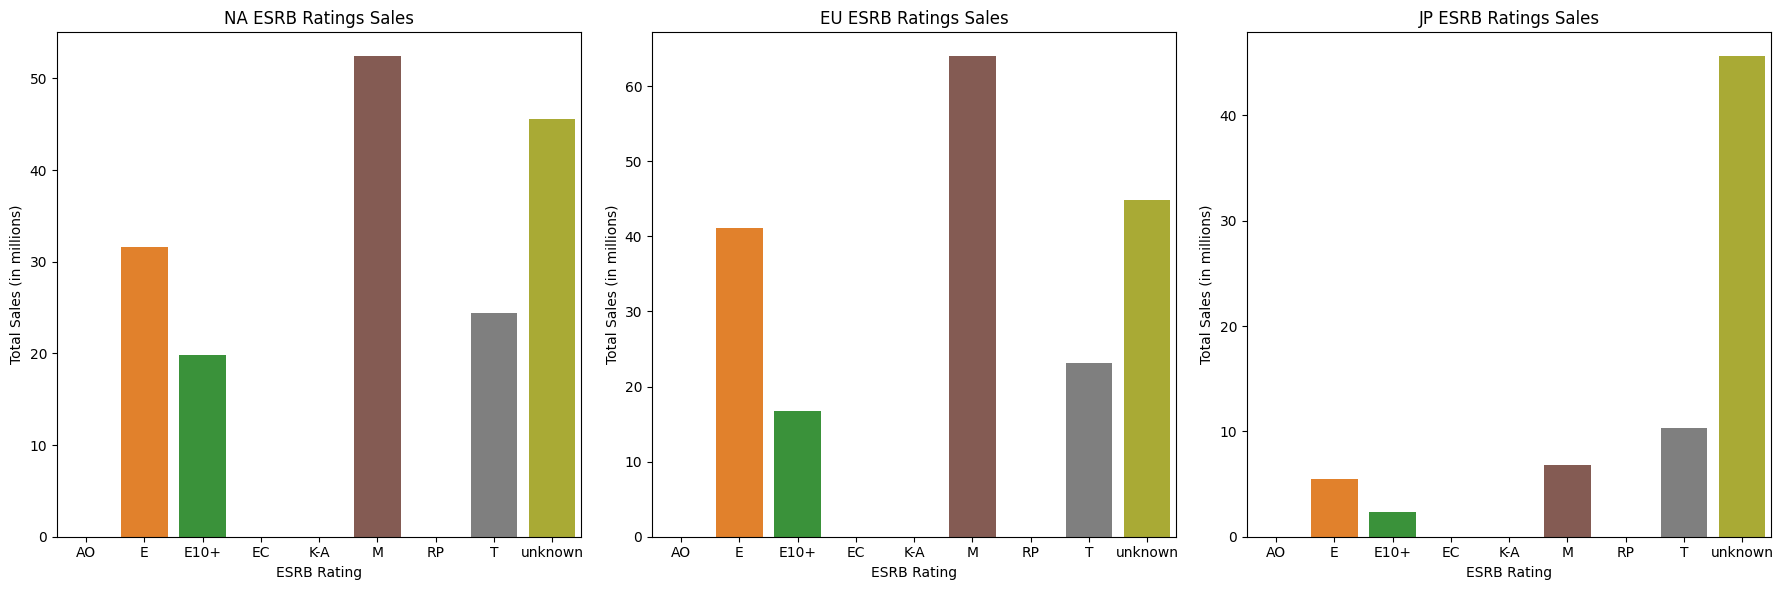

In [25]:
# Step 1: Top Five Platforms by Region
def top_five_platforms_by_region(region_column):
    platform_sales = filtered_data.groupby('platform')[region_column].sum().sort_values(ascending=False)
    return platform_sales.head(5)

top_na_platforms = top_five_platforms_by_region('na_sales')
top_eu_platforms = top_five_platforms_by_region('eu_sales')
top_jp_platforms = top_five_platforms_by_region('jp_sales')

print("Top 5 Platforms in NA:", top_na_platforms)
print("Top 5 Platforms in EU:", top_eu_platforms)
print("Top 5 Platforms in JP:", top_jp_platforms)

# Step 2: Top Five Genres by Region
def top_five_genres_by_region(region_column):
    genre_sales = filtered_data.groupby('genre')[region_column].sum().sort_values(ascending=False)
    return genre_sales.head(5)

top_na_genres = top_five_genres_by_region('na_sales')
top_eu_genres = top_five_genres_by_region('eu_sales')
top_jp_genres = top_five_genres_by_region('jp_sales')

print("Top 5 Genres in NA:", top_na_genres)
print("Top 5 Genres in EU:", top_eu_genres)
print("Top 5 Genres in JP:", top_jp_genres)

# Step 3: ESRB Ratings Effect on Sales by Region
def esrb_sales_by_region(region_column):
    esrb_sales = filtered_data.groupby('rating')[region_column].sum().sort_values(ascending=False)
    return esrb_sales

na_esrb_sales = esrb_sales_by_region('na_sales')
eu_esrb_sales = esrb_sales_by_region('eu_sales')
jp_esrb_sales = esrb_sales_by_region('jp_sales')

print("ESRB Sales in NA:", na_esrb_sales)
print("ESRB Sales in EU:", eu_esrb_sales)
print("ESRB Sales in JP:", jp_esrb_sales)

# Plotting the ESRB sales by region, including 'unknown'
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.barplot(x=na_esrb_sales.index, y=na_esrb_sales.values)
plt.title('NA ESRB Ratings Sales')
plt.xlabel('ESRB Rating')
plt.ylabel('Total Sales (in millions)')

plt.subplot(1, 3, 2)
sns.barplot(x=eu_esrb_sales.index, y=eu_esrb_sales.values)
plt.title('EU ESRB Ratings Sales')
plt.xlabel('ESRB Rating')
plt.ylabel('Total Sales (in millions)')

plt.subplot(1, 3, 3)
sns.barplot(x=jp_esrb_sales.index, y=jp_esrb_sales.values)
plt.title('JP ESRB Ratings Sales')
plt.xlabel('ESRB Rating')
plt.ylabel('Total Sales (in millions)')

plt.tight_layout()
plt.show()


North American sales are dominated by M (Mature) rating, followed by E (Everyone). T (Teen) and E10+ (Everyone 10+) are on the lower end of sales. AO (Adults only), EC (Early Childhood), and RP (Rating Pending) are not represented in the data. 

The relationship between ESRB ratings and sales in the EU mirrors that in North America. 

The Japanese market is dominated by sales rated E. Games rated T and M are also significant in sales. E10+ game sales are low. 

These null and alterntive hypotheses were formulated to identify any significant difference between average user ratings on both platforms. 
Test 1:
H0: The average user ratings between Xbox One and PC are different. 

H1: The average user ratings between Xbox One and PC are the same. 

Test 2:
H0: The average user ratings between Action and Sports genres are different. 

H1: The average user ratings between Action and Sports genres are the same. 

Alpha of 0.05 was used to minimize the risk of incorrectly rejecting a true null hypothesis. 

In [27]:
# Step 1: Filter data for the platforms and genres of interest
xbox_one_ratings = relevant_data[(relevant_data['platform'] == 'XOne')]['user_score'].dropna()
pc_ratings = relevant_data[(relevant_data['platform'] == 'PC')]['user_score'].dropna()


In [28]:
# Perform Levene's test for equality of variances
levene_stat, levene_p_val = stats.levene(xbox_one_ratings, pc_ratings)

# Perform Bartlett's test for equality of variances
bartlett_stat, bartlett_p_val = stats.bartlett(xbox_one_ratings, pc_ratings)

print(f"Levene's test p-value: {levene_p_val}")
print(f"Bartlett's test p-value: {bartlett_p_val}")

# Use the p-value from Levene's or Bartlett's test to decide on equal_var
if levene_p_val > 0.05 and bartlett_p_val > 0.05:
    equal_var = True
    print("Assuming equal variances.")
else:
    equal_var = False
    print("Assuming unequal variances.")

# Now perform the t-test with the appropriate equal_var setting
t_stat, p_val = stats.ttest_ind(xbox_one_ratings, pc_ratings, equal_var=equal_var, nan_policy='omit')

print(f"t-statistic: {t_stat}, p-value: {p_val}")


Levene's test p-value: 0.30979234107221576
Bartlett's test p-value: 0.10675994931766565
Assuming equal variances.
t-statistic: -4.14273278153197, p-value: 3.750185722417337e-05


In [29]:

action_ratings = relevant_data[(relevant_data['genre'] == 'Action')]['user_score'].dropna()
sports_ratings = relevant_data[(relevant_data['genre'] == 'Sports')]['user_score'].dropna()

# Step 2: Test for equality of variances

# Levene's test for Xbox One vs. PC
levene_stat1, levene_p_val1 = stats.levene(xbox_one_ratings, pc_ratings)
# Bartlett's test for Xbox One vs. PC
bartlett_stat1, bartlett_p_val1 = stats.bartlett(xbox_one_ratings, pc_ratings)

# Levene's test for Action vs. Sports
levene_stat2, levene_p_val2 = stats.levene(action_ratings, sports_ratings)
# Bartlett's test for Action vs. Sports
bartlett_stat2, bartlett_p_val2 = stats.bartlett(action_ratings, sports_ratings)

# Determine equal_var parameter for Xbox One vs. PC
if levene_p_val1 > 0.05 and bartlett_p_val1 > 0.05:
    equal_var1 = True
    print("Assuming equal variances for Xbox One vs. PC.")
else:
    equal_var1 = False
    print("Assuming unequal variances for Xbox One vs. PC.")

# Determine equal_var parameter for Action vs. Sports
if levene_p_val2 > 0.05 and bartlett_p_val2 > 0.05:
    equal_var2 = True
    print("Assuming equal variances for Action vs. Sports.")
else:
    equal_var2 = False
    print("Assuming unequal variances for Action vs. Sports.")

# Step 3: Perform two-sample t-tests with the appropriate equal_var parameter

# Hypothesis 1: Xbox One vs. PC user ratings
t_stat1, p_val1 = stats.ttest_ind(xbox_one_ratings, pc_ratings, equal_var=equal_var1, nan_policy='omit')

# Hypothesis 2: Action vs. Sports user ratings
t_stat2, p_val2 = stats.ttest_ind(action_ratings, sports_ratings, equal_var=equal_var2, nan_policy='omit')

# Step 4: Output the results
alpha = 0.05

print(f"\nHypothesis 1: Xbox One vs. PC User Ratings")
print(f"t-statistic: {t_stat1}, p-value: {p_val1}")
if p_val1 < alpha:
    print("Reject the null hypothesis: The average user ratings are different.")
else:
    print("Fail to reject the null hypothesis: The average user ratings are the same.")

print("\nHypothesis 2: Action vs. Sports User Ratings")
print(f"t-statistic: {t_stat2}, p-value: {p_val2}")
if p_val2 < alpha:
    print("Reject the null hypothesis: The average user ratings are different.")
else:
    print("Fail to reject the null hypothesis: The average user ratings are the same.")


Assuming equal variances for Xbox One vs. PC.
Assuming unequal variances for Action vs. Sports.

Hypothesis 1: Xbox One vs. PC User Ratings
t-statistic: -4.14273278153197, p-value: 3.750185722417337e-05
Reject the null hypothesis: The average user ratings are different.

Hypothesis 2: Action vs. Sports User Ratings
t-statistic: 1.640035237403321, p-value: 0.10115120156606783
Fail to reject the null hypothesis: The average user ratings are the same.


This project analyzed video game sales data to uncover trends in platform and genre popularity across different regions. It found that preferences for gaming platforms and genres vary by region, with Action and Shooter games being popular globally, but RPGs being a favorite in Japan. Additionally, the study showed that critic reviews have a significant impact on sales, especially in North America and the EU markets, while user ratings are more influential in some regions like Japan.